<a href="https://colab.research.google.com/github/killer-shark00/Abstractive-Text-Summarization/blob/main/suvidha_foundation_abstractive_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Needed package

In [ ]:
!pip install -U nltk # To Upgrade NLTK to >3.8.1 for METEOR score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk

print('The nltk version is {}.'.format(nltk.__version__)) # Verify version >3.

The nltk version is 3.8.1.


In [ ]:
import numpy as np 
import pandas as pd

## Import CSV file -- dataset 

CNN's Daily mail https://github.com/danqi/rc-cnn-dailymail

In [ ]:
# load csv file using pandas.
file_path = "/content/drive/MyDrive/Intership/cnn_dailymail/train.csv"
data = pd.read_csv(file_path)
data.shape

(287113, 3)

In [ ]:
# we will only use the last two columns Highlights (target) and Article (input).
data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundr...","Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,"(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, author...","Criminal complaint: Cop used his role to help cocaine traffickers .\nRalph Mata, an internal affairs lieutenant, allegedly helped group get guns .\nHe also arranged to pay two assassins in a murde..."
2,00027e965c8264c35cc1bc55556db388da82b07f,"A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he r...","Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titl..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,"(CNN) -- With a breezy sweep of his pen President Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the region to a future returned to Russian domain. Sixty years prio...","Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .\nTargeting Russia's business community would be one way of sapping their support for President Putin, she says ..."
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playing in the third tier ...,"Fleetwood top of League One after 2-0 win at Scunthorpe .\nPeterborough, Bristol City, Chesterfield and Crawley all drop first points of the season .\nStand-in striker Matt Done scores a hat-trick..."


In [ ]:
# only summary and text are useful for us.
data = data[['highlights', 'article']]
data.head()

,highlights,article
0,"Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown...","By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundr..."
1,"Criminal complaint: Cop used his role to help cocaine traffickers .\nRalph Mata, an internal affairs lieutenant, allegedly helped group get guns .\nHe also arranged to pay two assassins in a murde...","(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, author..."
2,"Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titl...","A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he r..."
3,"Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .\nTargeting Russia's business community would be one way of sapping their support for President Putin, she says ...","(CNN) -- With a breezy sweep of his pen President Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the region to a future returned to Russian domain. Sixty years prio..."
4,"Fleetwood top of League One after 2-0 win at Scunthorpe .\nPeterborough, Bristol City, Chesterfield and Crawley all drop first points of the season .\nStand-in striker Matt Done scores a hat-trick...",Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playing in the third tier ...


## Seq2Seq LSTM Modelling

In [ ]:
data['article'][:10]

0    By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundr...
1    (CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, author...
2    A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he r...
3    (CNN) -- With a breezy sweep of his pen President Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the region to a future returned to Russian domain. Sixty years prio...
4    Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playi

### Perform Data Cleansing

In [ ]:
#Check how much % of summary have 0-400 words
count=0
for i in data['highlights']:
    if(len(i.split())<=80):
        count=count+1
print(count/len(data['highlights']))

0.9176839780852835


In [ ]:
#Check how much % of text have 0-1000 words
count=0
for i in data['article']:
    if(len(i.split())<=100):
        count=count+1
print(count/len(data['article']))

0.0015638442007153979


In [ ]:
#Model to summarize the text between 0-400 words for Summary and 0-1000 words for Text

max_text_len= 100
max_summary_len=80

### Read clean data

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(data['article'])
cleaned_summary=np.array(data['highlights'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre_data=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre_data.head(2)

,text,summary
0,"(CNN Student News) -- September 2, 2011 . Download PDF maps related to today's show: . • Oklahoma & Texas • Iraq • Tripoli, Libya . Click here to access the transcript of today's CNN Student News ...",The daily transcript is a written version of each day's CNN Student News program .\nUse this transcript to help students with reading comprehension and vocabulary .\nUse the weekly Newsquiz to tes...
1,"(CNN) -- Former baseball slugger Jose Canseco accidentally shot himself in his left finger while cleaning a gun, police said. He was in surgery Tuesday night, his fiancee tweeted. ""This is Leila ....",Canseco hit more than 450 home runs .\nHis semiautomatic handgun accidentally went off .


In [ ]:
#Add sostok and eostok at 
post_pre_data['summary'] = post_pre_data['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
post_pre_data.head(2)

,text,summary
0,"(CNN Student News) -- September 2, 2011 . Download PDF maps related to today's show: . • Oklahoma & Texas • Iraq • Tripoli, Libya . Click here to access the transcript of today's CNN Student News ...",sostok The daily transcript is a written version of each day's CNN Student News program .\nUse this transcript to help students with reading comprehension and vocabulary .\nUse the weekly Newsquiz...
1,"(CNN) -- Former baseball slugger Jose Canseco accidentally shot himself in his left finger while cleaning a gun, police said. He was in surgery Tuesday night, his fiancee tweeted. ""This is Leila ....",sostok Canseco hit more than 450 home runs .\nHis semiautomatic handgun accidentally went off . eostok


## SEQ2SEQ MODEL BUILDING

### Split the data to TRAIN and VALIDATION sets

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre_data['text']),np.array(post_pre_data['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer() 
x_tknizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**

total_count gives the size of vocabulary (which means every unique words in the text)

count gives me the no. of rare words whose count falls below threshold

total_count - count gives me the top most common words

In [ ]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in x_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 79.81088254810884
Total Coverage of rare words: 22.407830342577487


In [ ]:
#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer(num_words=total_count-count) 
x_tknizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tknizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tknizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tknizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 1218


**RARE WORD ANALYSIS FOR Y i.e 'summary'**

total_count gives the size of vocabulary (which means every unique words in the text)

count gives me the no. of rare words whose count falls below threshold

total_count - count gives me the top most common words

In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer()   
y_tknizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 92.00844390832327
Total Coverage of rare words: 36.2415592387968


In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer(num_words=total_count-count) 
y_tknizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tknizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tknizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tknizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 266


We will now delete "Summary" i.e Y (both train and val) which has only START and END

In [ ]:
ind=[]
for i in range(len(y_tr)):
    count=0
    for j in y_tr[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    count=0
    for j in y_val[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
from tensorflow import keras
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from nltk.corpus import stopwords
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras import Model
from keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     243600      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=50)

In [ ]:
print(y_tr)

[[  2   1  28 ...   0   0   0]
 [  2   7  10 ...   0   0   0]
 [  2   1  28 ...   0   0   0]
 ...
 [  2   1  28 ...   0   0   0]
 [  2 111 124 ...   0   0   0]
 [  2  72  63 ...   0   0   0]]


### Start fitting the model with the data

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/5
13/13 [==============================] - 112s 8s/step - loss: 2.4743 - val_loss: 1.3908
Epoch 2/5
13/13 [==============================] - 90s 7s/step - loss: 1.5038 - val_loss: 1.3015
Epoch 3/5
13/13 [==============================] - 95s 7s/step - loss: 1.4547 - val_loss: 1.2936
Epoch 4/5
13/13 [==============================] - 89s 7s/step - loss: 1.4133 - val_loss: 1.2382
Epoch 5/5
13/13 [==============================] - 83s 6s/step - loss: 1.3088 - val_loss: 1.1337


### Save model weights

In [ ]:
model.save_weights('/content/drive/MyDrive/Intership/fitted_model')

### Load model weights

In [ ]:
model = model.load_weights('/content/drive/MyDrive/Intership/fitted_model')

**Plot model learning curve**

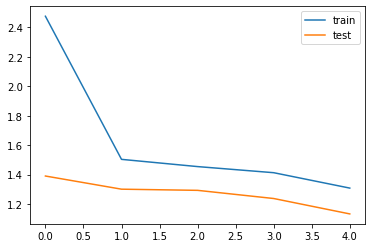

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tknizer.index_word
reverse_source_word_index=x_tknizer.index_word
target_word_index=y_tknizer.word_index

In [ ]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

# initial states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if sampled_token_index in reverse_target_word_index:
            sampled_token = reverse_target_word_index[sampled_token_index]
        else:
            sampled_token = '[UNK]'
        
        # sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Predict and print summaries from **model**

In [ ]:
for i in range(0,10):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",(sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence(x_tr[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    print("\n")

Review: cnn student news february 1 2013 download pdf maps related to today's show washington d c north carolina click here to access the transcript of today's cnn student news program please note that there may be a delay between the time when the video is available and when the transcript is published 
Original summary: the daily transcript is a written version of each day's cnn student news program use this transcript to help students with reading comprehension and vocabulary use the weekly newsquiz to test your knowledge of stories you saw on cnn student news 
1/1 [==============================] - 0s 30ms/step
Predicted summary:  the the the [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UN

## Calculating **Rogue score**

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# print(decode_sequence(x_tr[1].reshape(1,max_text_len))) 

In [ ]:
from rouge import Rouge

In [ ]:
rouge = Rouge()

In [ ]:
for i in range(0,1):
        generated_summary = sequence_to_summary(y_tr[i])
        summary = decode_sequence(x_tr[i])


        print(rouge.get_scores(generated_summary, summary))

[{'rouge-1': {'r': 0.030303030303030304, 'p': 0.09090909090909091, 'f': 0.04545454170454576}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.030303030303030304, 'p': 0.09090909090909091, 'f': 0.04545454170454576}}]
